<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/model_cnn_to_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
import tensorflow as tf
import copy as cp

In [2]:
df = pd.read_csv('/content/df_cov_continu_1_1.txt', index_col=0, parse_dates=True,sep=',')
N=len(list(df.iloc[:,3]))
df_train=df.iloc[0:round(N*0.8),:]
df_test=df.iloc[round(N*0.8):N,:]

In [3]:
mesure=["Fecha","Hora"];
mesure.append("Voltaje_(R)_[V]")	
mesure.append("Voltaje_(S)_[V]")	
mesure.append("Voltaje_(T)_[V]")	
mesure.append("Voltaje_(RS)_[V]")	
mesure.append("Voltaje_(ST)_[V]")	
mesure.append("Voltaje_(TR)_[V]")	
mesure.append("Corriente_R_[A]")	
mesure.append("Corriente_S_[A]")	
mesure.append("Corriente_T_[A]")	
mesure.append("Potencia_R_[VA]")	
mesure.append("Potencia_S_[VA]")	
mesure.append("Potencia_T_[VA]")	
mesure.append("Potencia_R_[W]")	
mesure.append("Potencia_S_[W]")	
mesure.append("Potencia_T_[W]")	
mesure.append("Potencia_R_[VAR]")	
mesure.append("Potencia_S_[VAR]")	
mesure.append("Potencia_T_[VAR]")	
mesure.append("Corriente_N_[A]")	
mesure.append("Frecuencia_[Hz]")	
mesure.append("not_sure_1")	
mesure.append("not_sure_2")	
mesure.append("not_sure_3")	
mesure.append("Potencia_3F_[KVA]")	
mesure.append("Potencia_3F_[W]")	
mesure.append("Potencia_3F_[VAR]")	
mesure.append("Factor de Potencia")

In [4]:
RSG_train = df_train[mesure[10]].values
window_len=4000
long=len(RSG_train)
Q=long-window_len
Spectro=np.zeros((1000,17,Q))
Y=[]

In [5]:
RSG_test = df_test[mesure[10]].values

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler()

In [8]:
scaler.fit(RSG_train.reshape(-1,1))

MinMaxScaler()

In [9]:
scaled_train = scaler.transform(RSG_train.reshape(-1,1))
scaled_test = scaler.transform(RSG_test.reshape(-1,1))

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
n_steps=20
n_features=1
X,y=split_sequence(scaled_train,n_steps)
X_test,y_test=split_sequence(scaled_test,n_steps)

In [12]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

In [13]:

# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [14]:
X = X.reshape(X.shape[0], X.shape[1], n_features)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],n_features)

In [15]:
model.fit(X, y, epochs=10, verbose=1,batch_size=100,validation_data=(X_test,y_test))

Epoch 1/10
82/82 [==============================] - 1s 8ms/step - loss: 0.0153 - val_loss: 0.0020
Epoch 2/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 4/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 9.3127e-04
Epoch 6/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 9.0553e-04
Epoch 7/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 9.0599e-04
Epoch 8/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.8735e-04
Epoch 9/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 9.0540e-04
Epoch 10/10
82/82 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.6658

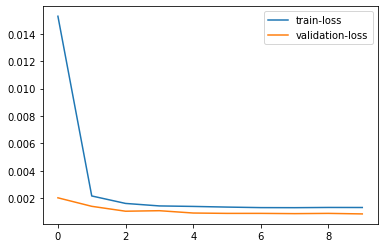

In [16]:
loss_per_epoch = model.history.history['loss']
loss_vall=model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.legend()

In [17]:
Q=0
N=50

In [18]:
test_predictions = []
first_eval_batch = scaled_train[Q:Q+n_steps]
current_batch = first_eval_batch.reshape((1, n_steps, n_features))
for i in range(N):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [19]:
L_true=  list(df_train[mesure[10]][n_steps+1+Q:n_steps+1+Q+N])

In [20]:
trainPredict = model.predict(X)
testPredict = model.predict_generator(X_test)
true_pre=scaler.inverse_transform(trainPredict)
true_pre_test=scaler.inverse_transform(testPredict)
test_predictions_true=scaler.inverse_transform(test_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


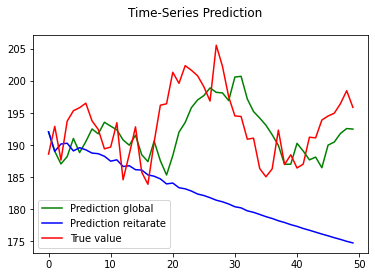

In [21]:
plt.suptitle('Time-Series Prediction')
plt.plot(range(len(L_true)),true_pre[Q:Q+N],label='Prediction global',c="green")
plt.plot(range(len(L_true)),test_predictions_true[Q:Q+N],label='Prediction reitarate',c="blue")
plt.plot(range(len(L_true)),L_true,label='True value',c="red")
plt.legend()
plt.show()

In [22]:
Resul_rmse=np.sqrt(mean_squared_error(true_pre_test,RSG_test[n_steps:]))
print(Resul_rmse)

5.5590375295662495


In [23]:
def create_model(num_filters,kernel_size,activation,n_steps,pool_size,layers):
  model=Sequential()
  assert(len(kernel_size)==layers==len(num_filters)==len(pool_size))
  if layers > 1:
    model.add(Conv1D(filters=num_filters[0], kernel_size=kernel_size[0], activation=activation, input_shape=(n_steps,1)))
    model.add(MaxPooling1D(pool_size=pool_size[0],padding='same'))
    for j in range(1,layers):
      model.add(Conv1D(filters=num_filters[j], kernel_size=kernel_size[j], activation=activation))
      model.add(MaxPooling1D(pool_size=pool_size[j],padding='same'))
  else:
    model.add(Conv1D(filters=num_filters[0], kernel_size=kernel_size[0], activation=activation, input_shape=(n_steps,1)))
    model.add(MaxPooling1D(pool_size=pool_size[0],padding='same'))
  model.add(Flatten())
  model.add(Dense(50,activation='relu'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  return model

In [24]:
layers1=[1,2,3]
num_filters=[[64],[64,32],[64,32,16]]
kernel_size=[[4],[4,3],[4,3,2]]
activation=["relu","elu","exponential","sigmoid","tanh"]
pool_size=[[3],[2,2],[2,2,1]]
import json

In [25]:
min_RMSE=100000
for k in range(3):
  for activa in activation:
    model_t=create_model(num_filters[k],kernel_size[k],activa,n_steps,pool_size[k],layers1[k]) 
    print({
          'num_filters':num_filters[k],
          'Kernal_size(s)':kernel_size[k],
          'Activation':activa,
          'pool_size(s)': pool_size[k],
          'Number of layers':layers1[k],
      })
    model_t.fit(X, y, epochs=30, verbose=0,batch_size=100)
    predictions_1=model_t.predict(X_test)
    true_predictions1 = scaler.inverse_transform(predictions_1.reshape(-1,1))
    rsg_predictions = true_predictions1[:,0]
    true_values = np.ndarray.flatten(df_test.iloc[n_steps:][mesure[14]].values)
    errorMSE = mean_squared_error(true_values,rsg_predictions)
    errorMAE = mean_absolute_error(true_values,rsg_predictions)
    errorRMSE = np.sqrt(errorMSE)
    if(errorRMSE<min_RMSE):
      print('BEST')
      model.save("./drive/MyDrive/DatosInvestigacion/CNN_HP_RS.h5","a")
      min_RMSE = errorRMSE

    print('RMSE:',errorRMSE)
    print('MAE',errorMAE)
    print('min RMSE',min_RMSE)
    resultado = {
        'num_filters':num_filters[k],
        'Kernal_size(s)':kernel_size[k],
        'Activation':activa,
        'pool_size(s)': pool_size[k],
        'Number of layers':layers1[k],
        'MSE':errorMSE,
        'MAE':errorMAE,
        'RMSE':errorRMSE
      }
    with open("./drive/MyDrive/DatosInvestigacion/CNN_HP_RS.txt","a") as file:
      resultado = json.dumps(resultado)
      file.write(resultado)
      file.write('\n')

{'num_filters': [64], 'Kernal_size(s)': [4], 'Activation': 'relu', 'pool_size(s)': [3], 'Number of layers': 1}
BEST
RMSE: 14820.481585253287
MAE 14061.023893216154
min RMSE 14820.481585253287
{'num_filters': [64], 'Kernal_size(s)': [4], 'Activation': 'elu', 'pool_size(s)': [3], 'Number of layers': 1}
BEST
RMSE: 14819.93572475633
MAE 14060.368361299576
min RMSE 14819.93572475633
{'num_filters': [64], 'Kernal_size(s)': [4], 'Activation': 'exponential', 'pool_size(s)': [3], 'Number of layers': 1}
RMSE: 14824.344974802718
MAE 14064.988022244775
min RMSE 14819.93572475633
{'num_filters': [64], 'Kernal_size(s)': [4], 'Activation': 'sigmoid', 'pool_size(s)': [3], 'Number of layers': 1}
BEST
RMSE: 14815.259804567699
MAE 14055.23943312305
min RMSE 14815.259804567699
{'num_filters': [64], 'Kernal_size(s)': [4], 'Activation': 'tanh', 'pool_size(s)': [3], 'Number of layers': 1}
RMSE: 14820.749573858027
MAE 14061.3068597285
min RMSE 14815.259804567699
{'num_filters': [64, 32], 'Kernal_size(s)': [4,

In [26]:
precedent_result1=[]

In [27]:
with open("./drive/MyDrive/DatosInvestigacion/CNN_HP_RS.txt",'r') as fp:
    for line in fp:
      precedent_result1.append(json.loads(line))

In [28]:
df_result = pd.DataFrame(precedent_result1)

In [29]:
best_param_s=df_result[df_result['RMSE']==df_result['RMSE'].min()]
best_param2=df_result[df_result['MAE']==df_result['MAE'].min()]
print(best_param_s)

     num_filters Kernal_size(s) Activation pool_size(s)  Number of layers  \
14  [64, 32, 16]      [4, 3, 2]       tanh    [2, 2, 1]                 3   

              MSE         MAE        RMSE  
14  710785.618292  595.693284  843.081027  


In [30]:
df_result.head(15)

,num_filters,Kernal_size(s),Activation,pool_size(s),Number of layers,MSE,MAE,RMSE
0,[64],[4],relu,[3],1,7.650357e+05,621.826403,874.663209
1,[64],[4],elu,[3],1,8.836989e+05,687.997906,940.052579
2,[64],[4],exponential,[3],1,1.468983e+06,879.135409,1212.016012
3,[64],[4],sigmoid,[3],1,1.831410e+06,1011.546227,1353.296040
4,[64],[4],tanh,[3],1,9.118313e+05,687.398181,954.898598
5,"[64, 32]","[4, 3]",relu,"[2, 2]",2,7.108850e+05,595.637368,843.139974
6,"[64, 32]","[4, 3]",elu,"[2, 2]",2,7.443684e+05,611.666803,862.767878
7,"[64, 32]","[4, 3]",exponential,"[2, 2]",2,2.715130e+06,1366.327511,1647.765078
8,"[64, 32]","[4, 3]",sigmoid,"[2, 2]",2,1.217603e+06,838.561913,1103.450374
9,"[64, 32]","[4, 3]",tanh,"[2, 2]",2,7.610688e+05,620.610264,872.392544
